In [1]:
# 'https://hilpisch.com/tr_eikon_eod_data.csv'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
plt.style.use('seaborn-v0_8')
# print(plt.style.available)

In [2]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import cufflinks as cf

In [3]:
p = 0.55

In [4]:
f = p - (1 - p)

In [5]:
f

0.10000000000000009

In [6]:
I = 50

In [7]:
n = 100

In [8]:
def run_simulation(f):
  c = np.zeros((n, I))
  c[0] = 100
  for i in range(I):
    for t in range(1, n):
      o = np.random.binomial(1, p)
      if o > 0:
        c[t, i] = (1 + f) * c[t - 1, i]
      else:
        c[t, i] = (1 - f) * c[t - 1, i]
  return c

In [9]:
c_1 = run_simulation(f)

In [10]:
c_1.round(2)

array([[ 100.  ,  100.  ,  100.  , ...,  100.  ,  100.  ,  100.  ],
       [ 110.  ,   90.  ,  110.  , ...,   90.  ,   90.  ,   90.  ],
       [ 121.  ,   81.  ,   99.  , ...,   81.  ,   81.  ,   81.  ],
       ...,
       [ 922.22,  226.35,   82.99, ...,   67.9 ,  185.2 ,  413.27],
       [1014.44,  203.72,   91.29, ...,   61.11,  203.72,  371.94],
       [1115.89,  183.34,   82.16, ...,   67.22,  183.34,  334.75]])

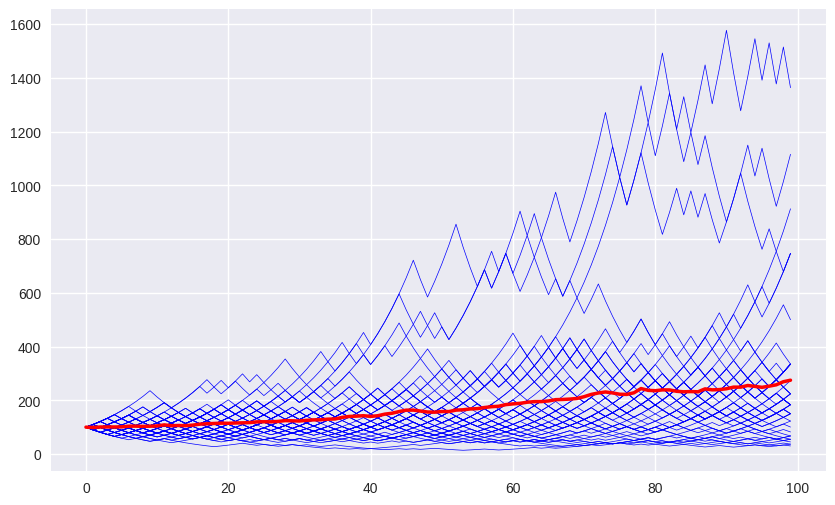

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(c_1, 'b', lw=0.5)
plt.plot(c_1.mean(axis=1), 'r', lw=2.5);

In [12]:
c_2 = run_simulation(0.05)

In [13]:
c_3 = run_simulation(0.25)

In [14]:
c_4 = run_simulation(0.5)

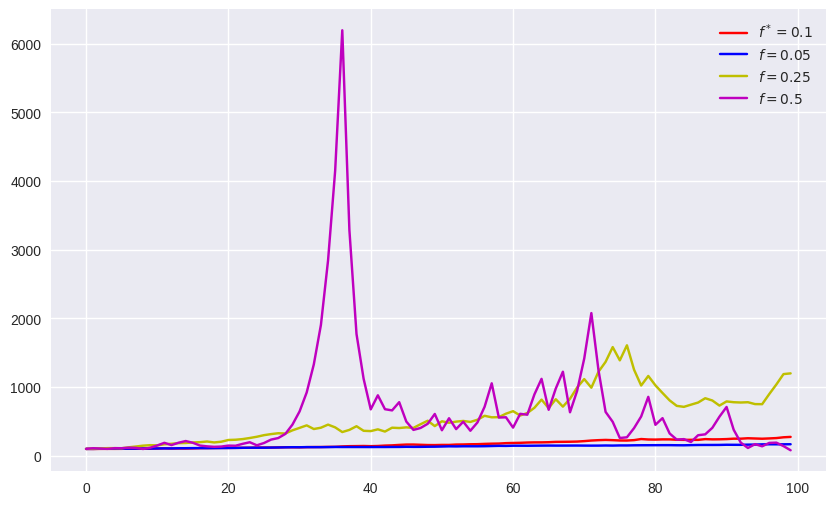

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f=0.5$')
plt.legend(loc=0);

In [16]:
raw = pd.read_csv('https://hilpisch.com/tr_eikon_eod_data.csv',
 index_col=0, parse_dates=True)

In [17]:
symbol = '.SPX'

In [18]:
data = pd.DataFrame(raw[symbol])

In [19]:
data['returns'] = np.log(data / data.shift(1))

In [20]:
data.dropna(inplace=True)

In [21]:
data.tail()

,.SPX,returns
Date,,
2018-06-25,2717.07,-0.013820
2018-06-26,2723.06,0.002202
2018-06-27,2699.63,-0.008642
2018-06-28,2716.31,0.006160
2018-06-29,2718.37,0.000758


In [22]:
data.head()

,.SPX,returns
Date,,
2010-01-05,1136.52,0.003111
2010-01-06,1137.14,0.000545
2010-01-07,1141.69,0.003993
2010-01-08,1144.98,0.002878
2010-01-11,1146.98,0.001745


In [23]:
mu = data.returns.mean() * 252

In [24]:
mu

0.09898579893004976

In [25]:
sigma = data.returns.std() * 252 ** 0.5

In [26]:
sigma

0.1488567510081968

In [27]:
r = 0.0

In [28]:
f = (mu - r) / sigma ** 2

In [29]:
f

4.467204367970679

In [30]:
equs = []

In [31]:
def kelly_strategy(f):
  global equs
  equ = 'equity_{:.2f}'.format(f)
  equs.append(equ)
  cap = 'capital_{:.2f}'.format(f)
  data[equ] = 1.0
  data[cap] = data[equ] * f
  for i, t in enumerate(data.index[1:]):
    t_1 = data.index[i]
    data.loc[t, cap] = data[cap].loc[t_1] * \
    math.exp(data['returns'].loc[t])
    data.loc[t, equ] = data[cap].loc[t] - \
    data[cap].loc[t_1] + \
    data[equ].loc[t_1]
    data.loc[t, cap] = data[equ].loc[t] * f

In [32]:
kelly_strategy(f * 0.5)

In [33]:
kelly_strategy(f * 0.66)

In [34]:
kelly_strategy(f)

In [35]:
print(data[equs].tail())

            equity_2.23  equity_2.95  equity_4.47
Date                                             
2018-06-25     4.707070     6.367340     8.794342
2018-06-26     4.730248     6.408727     8.880952
2018-06-27     4.639340     6.246147     8.539593
2018-06-28     4.703365     6.359932     8.775296
2018-06-29     4.711332     6.374152     8.805026


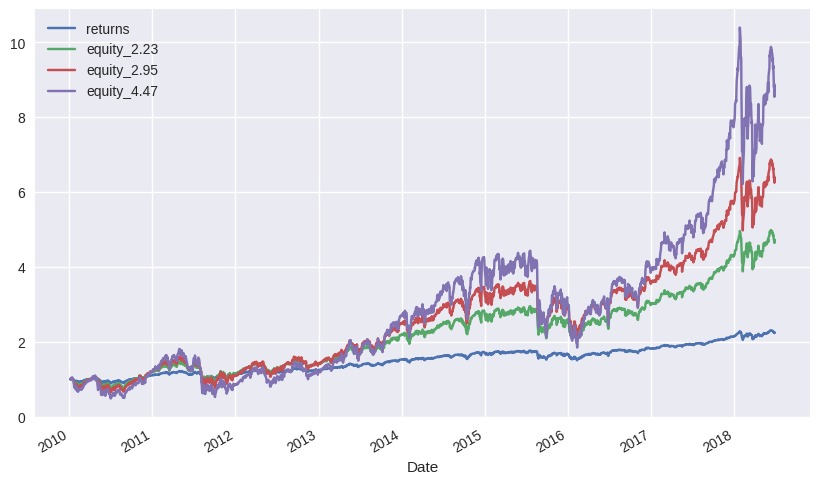

In [36]:
ax = data['returns'].cumsum().apply(np.exp).plot(legend=True,
 figsize=(10, 6))
data[equs].plot(ax=ax, legend=True);

# ML-Based Trading Strategy

In this section, using a Machine Learning based approach which predicts the direction of price movements, we develop a strategy for the EUR/USD currency pair from historial data with 5 minute candles.

In order to test the strategy, vectorized back testing is employed and the bid-ask spread used as a proportionality constant for the transaction costs.

We end up analyzing the risk metrics associated with our trading strategy.

In [37]:
# Ask data
data1 = pd.read_csv('/content/EURUSD_Candlestick_5_M_BID_31.05.2018-29.06.2018.csv',
 index_col=0, parse_dates=True)
data1 = data1[data1['Volume'] != 0]
data1.drop(columns='Volume', inplace=True)
data1.rename(columns={"Open": "bidopen", "High": "bidhigh", "Low": "bidlow", "Close": "bidclose"}, inplace=True)


# Bid data
data2 = pd.read_csv('/content/EURUSD_Candlestick_5_M_ASK_31.05.2018-29.06.2018.csv',
 index_col=0, parse_dates=True)
data2 = data2[data2['Volume'] != 0]
data2.drop(columns='Volume', inplace=True)
data2.rename(columns={"Open": "askopen", "High": "askhigh", "Low": "asklow", "Close": "askclose"}, inplace=True)

In [38]:
# Checking rows and columns
data1.shape, data2.shape

((6012, 4), (6012, 4))

In [39]:
# Making sure the indices match
if data1.index.equals(data2.index):
    print("The dataframes have the same index.")
else:
    print("The dataframes do not have the same index.")

The dataframes have the same index.


In [40]:
# Combined data in a single dataframe
data = pd.concat([data1, data2], axis=1)

In [41]:
data.tail()

,bidopen,bidhigh,bidlow,bidclose,askopen,askhigh,asklow,askclose
Gmt time,,,,,,,,
29.06.2018 20:35:00.000,1.16849,1.16889,1.16834,1.16875,1.16854,1.16895,1.16840,1.16885
29.06.2018 20:40:00.000,1.16875,1.16893,1.16848,1.16848,1.16885,1.16900,1.16856,1.16857
29.06.2018 20:45:00.000,1.16849,1.16859,1.16818,1.16821,1.16858,1.16866,1.16825,1.16829
29.06.2018 20:50:00.000,1.16819,1.16840,1.16811,1.16826,1.16829,1.16849,1.16822,1.16835
29.06.2018 20:55:00.000,1.16826,1.16862,1.16807,1.16847,1.16837,1.16867,1.16825,1.16858


In [42]:
data.index

Index(['01.06.2018 00:00:00.000', '01.06.2018 00:05:00.000',
       '01.06.2018 00:10:00.000', '01.06.2018 00:15:00.000',
       '01.06.2018 00:20:00.000', '01.06.2018 00:25:00.000',
       '01.06.2018 00:30:00.000', '01.06.2018 00:35:00.000',
       '01.06.2018 00:40:00.000', '01.06.2018 00:45:00.000',
       ...
       '29.06.2018 20:10:00.000', '29.06.2018 20:15:00.000',
       '29.06.2018 20:20:00.000', '29.06.2018 20:25:00.000',
       '29.06.2018 20:30:00.000', '29.06.2018 20:35:00.000',
       '29.06.2018 20:40:00.000', '29.06.2018 20:45:00.000',
       '29.06.2018 20:50:00.000', '29.06.2018 20:55:00.000'],
      dtype='object', name='Gmt time', length=6012)

In [43]:
# Transforming index to DatetimeIndex
data.index = pd.to_datetime(data.index, format="%d.%m.%Y %H:%M:%S.%f")
data.index

DatetimeIndex(['2018-06-01 00:00:00', '2018-06-01 00:05:00',
               '2018-06-01 00:10:00', '2018-06-01 00:15:00',
               '2018-06-01 00:20:00', '2018-06-01 00:25:00',
               '2018-06-01 00:30:00', '2018-06-01 00:35:00',
               '2018-06-01 00:40:00', '2018-06-01 00:45:00',
               ...
               '2018-06-29 20:10:00', '2018-06-29 20:15:00',
               '2018-06-29 20:20:00', '2018-06-29 20:25:00',
               '2018-06-29 20:30:00', '2018-06-29 20:35:00',
               '2018-06-29 20:40:00', '2018-06-29 20:45:00',
               '2018-06-29 20:50:00', '2018-06-29 20:55:00'],
              dtype='datetime64[ns]', name='Gmt time', length=6012, freq=None)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6012 entries, 2018-06-01 00:00:00 to 2018-06-29 20:55:00
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bidopen   6012 non-null   float64
 1   bidhigh   6012 non-null   float64
 2   bidlow    6012 non-null   float64
 3   bidclose  6012 non-null   float64
 4   askopen   6012 non-null   float64
 5   askhigh   6012 non-null   float64
 6   asklow    6012 non-null   float64
 7   askclose  6012 non-null   float64
dtypes: float64(8)
memory usage: 422.7 KB


In [45]:
# Calculating average bid-ask spread
spread = (data['askclose'] - data['bidclose']).mean()
spread

3.732202262142449e-05

In [46]:
# Average midclose price
data['midclose'] = (data['askclose'] + data['bidclose']) / 2

In [47]:
# Calculates the average proportional transaction costs given the average spread and average midclose prices
ptc = spread / data['midclose'].mean()
ptc

3.1962572855664065e-05

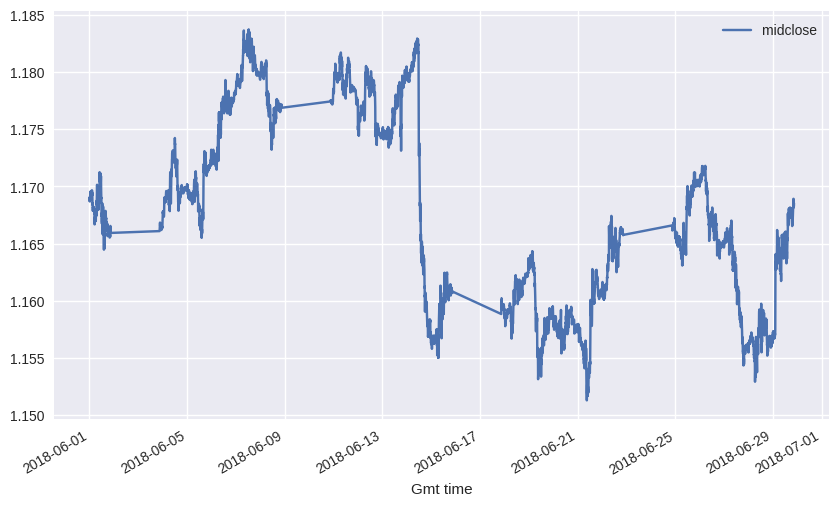

In [48]:
data['midclose'].plot(figsize=(10, 6), legend=True);

In [49]:
# Calculating returns
data['returns'] = np.log(data['midclose'] / data['midclose'].shift(1))

In [50]:
data['returns'].head()

,returns
Gmt time,
2018-06-01 00:00:00,NaN
2018-06-01 00:05:00,0.000026
2018-06-01 00:10:00,-0.000257
2018-06-01 00:15:00,0.000051
2018-06-01 00:20:00,-0.000090


In [51]:
data.dropna(inplace=True)

The following ML strategy learns from patters in the historical data and decides if an upward or downward movement is more likely for EUR/USD currency pair.

In [52]:
lags = 5

In [53]:
# Creates lag returns data for lags=5
cols = []
for lag in range(1, lags + 1):
  col = 'lag_{}'.format(lag)
  data[col] = data['returns'].shift(lag)
  cols.append(col)

In [54]:
data.dropna(inplace=True)

In [55]:
data[cols].head()

,lag_1,lag_2,lag_3,lag_4,lag_5
Gmt time,,,,,
2018-06-01 00:30:00,-0.000009,-0.000090,0.000051,-0.000257,0.000026
2018-06-01 00:35:00,0.000184,-0.000009,-0.000090,0.000051,-0.000257
2018-06-01 00:40:00,0.000081,0.000184,-0.000009,-0.000090,0.000051
2018-06-01 00:45:00,0.000081,0.000081,0.000184,-0.000009,-0.000090
2018-06-01 00:50:00,0.000137,0.000081,0.000081,0.000184,-0.000009


In [56]:
# Transform the feature values (returns) to binary data
data[cols] = np.where(data[cols] > 0, 1, 0)

In [57]:
data[cols].head()

,lag_1,lag_2,lag_3,lag_4,lag_5
Gmt time,,,,,
2018-06-01 00:30:00,0,0,1,0,1
2018-06-01 00:35:00,1,0,0,1,0
2018-06-01 00:40:00,1,1,0,0,1
2018-06-01 00:45:00,1,1,1,0,0
2018-06-01 00:50:00,1,1,1,1,0


In [58]:
# Creates column where return data is transformed to directional data
data['direction'] = np.where(data['returns'] > 0, 1, -1)

In [59]:
data[cols + ['direction']].head()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
Gmt time,,,,,,
2018-06-01 00:30:00,0,0,1,0,1,1
2018-06-01 00:35:00,1,0,0,1,0,1
2018-06-01 00:40:00,1,1,0,0,1,1
2018-06-01 00:45:00,1,1,1,0,0,1
2018-06-01 00:50:00,1,1,1,1,0,-1


In [60]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Creating SVC model with linear kernel
model = SVC(C=1, kernel='linear', gamma='auto')

# Splitting the data
split = int(len(data) * 0.80)

# Training model
train = data.iloc[:split].copy()

In [61]:
model.fit(train[cols], train['direction'])

SVC(C=1, gamma='auto', kernel='linear')

In [62]:
# Accuracy from the training data
accuracy_score(train['direction'], model.predict(train[cols]))

0.5172772689425479

In [63]:
test = data.iloc[split:].copy()

In [64]:
# Accuracy of test data
test['position'] = model.predict(test[cols])
accuracy_score(test['direction'], test['position'])

0.540765391014975

In [65]:
# Returns of strategy without costs
test['strategy'] = test['position'] * test['returns']

In [66]:
# Number of trades based on changes in the position
sum(test['position'].diff() != 0)

651

In [67]:
# When a trade takes place, transaction costs are subtracted from strategy log returns
test['strategy_tc'] = np.where(test['position'].diff() != 0,
test['strategy'] - ptc,
test['strategy'])

In [68]:
# Results
test[['returns', 'strategy', 'strategy_tc']].sum().apply(np.exp)

,0
returns,0.999320
strategy,1.026752
strategy_tc,1.005608


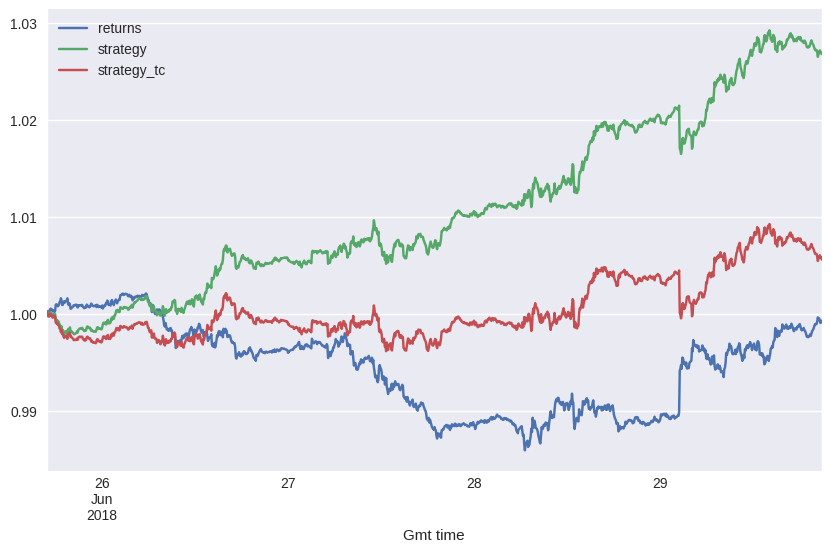

In [69]:
test[['returns', 'strategy', 'strategy_tc']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Optimal leverage

In [70]:
# Annualized mean return
mean = test[['returns', 'strategy_tc']].mean() * len(data) * 12
print(mean)

returns       -0.04078
strategy_tc    0.33532
dtype: float64


In [71]:
# Annualized variance
var = test[['returns', 'strategy_tc']].var() * len(data) * 12
print(var)

returns        0.007774
strategy_tc    0.007773
dtype: float64


In [72]:
# Annualized volatility
vol = var ** 0.5
vol

,0
returns,0.088171
strategy_tc,0.088167


In [73]:
# Optimal leverage according to Kelly criterion
print(mean / var)

returns        -5.245578
strategy_tc    43.136625
dtype: float64


In [74]:
# Optimal leverage according to half Kelly
print(mean / var * 0.5)

returns        -2.622789
strategy_tc    21.568313
dtype: float64


In [75]:
# Columns to plot
to_plot = ['returns', 'strategy_tc']

In [76]:
# Strategy returns for different leverages
for lev in [10, 20, 30, 40, 50]:
  label = 'lstrategy_tc_%d' % lev
  test[label] = test['strategy_tc'] * lev
  to_plot.append(label)

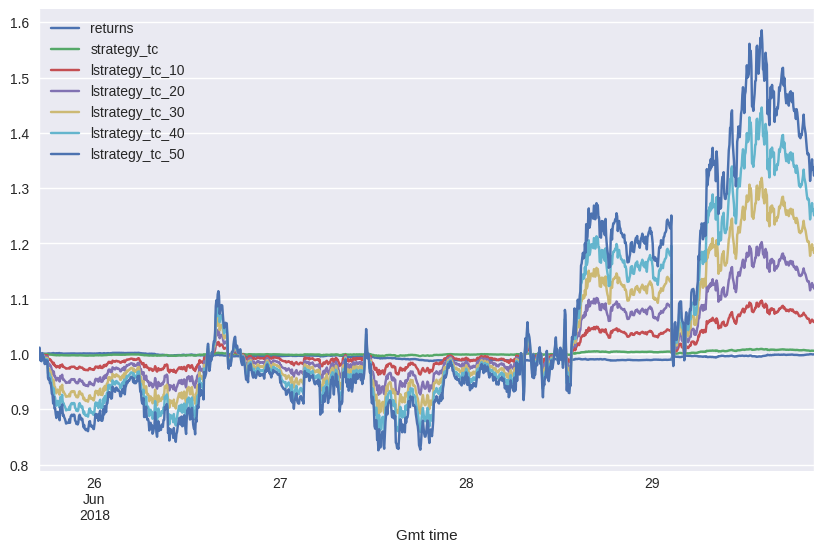

In [77]:
test[to_plot].cumsum().apply(np.exp).plot(figsize=(10, 6));

Clearly, from the plot above, we see that an increase in leverage also increases the volatility of the portfolio and, consequently, the risk associated to the strategy.

Therefore, conducting a risk analysis is crucial for gaining a deeper understanding of the strategy at hand.

# Risk Analysis

We assume that the initial equity position is 5000 EUR, which leads to an initial position of 100000 EUR for a leverage ratio of 20.

We will also assume that there are no adjustments to the equity position over time.

In [78]:
# Initial equity
equity = 5000

In [79]:
# Log returns with leverage ratio of 20
risk = pd.DataFrame(test['lstrategy_tc_20'])

In [82]:
# Total return scaled by initla equity position
risk['equity'] = risk['lstrategy_tc_20'].cumsum(
 ).apply(np.exp) * equity

In [84]:
# Cumulative maximum values over time
risk['cummax'] = risk['equity'].cummax()

In [85]:
# Drawdown values over time
risk['drawdown'] = risk['cummax'] - risk['equity']

In [86]:
# Maximum drawdown value
risk['drawdown'].max()

588.6544970843834

In [87]:
# Time where drawdown happens
t_max = risk['drawdown'].idxmax()
t_max

Timestamp('2018-06-27 12:40:00')

In [101]:
# Identifies highs
temp = risk['drawdown'][risk['drawdown'] == 0]

In [103]:
# Calculate timedelta values between all highs
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())

In [104]:
periods[20:30]

array([datetime.timedelta(seconds=600), datetime.timedelta(seconds=600),
       datetime.timedelta(seconds=300), datetime.timedelta(seconds=7800),
       datetime.timedelta(seconds=300), datetime.timedelta(seconds=600),
       datetime.timedelta(seconds=300), datetime.timedelta(seconds=4500),
       datetime.timedelta(seconds=300), datetime.timedelta(seconds=300)],
      dtype=object)

In [105]:
# Longest drawdown period
t_per = periods.max()

In [106]:
t_per

datetime.timedelta(days=1, seconds=82200)

In [107]:
# In hours
t_per.seconds / 60 / 60

22.833333333333332

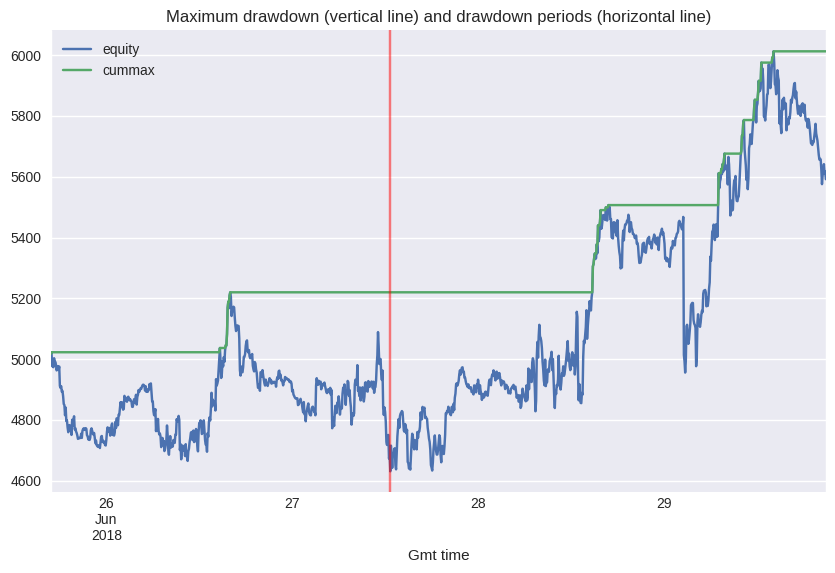

In [110]:
risk[['equity', 'cummax']].plot(figsize=(10, 6))
plt.axvline(t_max, c='r', alpha=0.5)
plt.title('Maximum drawdown (vertical line) and drawdown periods (horizontal line)');

Let us now determine the value-at-risk measure (VaR). The VaR represents the maximum loss to be expected given both a certain time horizon and a confidence level.

In what follows, we derive the VaR for the leveraged tranding strategy over time for different confidence levels.

In [113]:
import scipy.stats as scs

# Percentile values to be used
percs = np.array([0.01, 0.1, 1., 2.5, 5.0, 10.0])

In [112]:
# Log returns
risk['returns'] = np.log(risk['equity'] / risk['equity'].shift(1))

In [114]:
# VaR based on log returns for the different percentiles. Computes the value at a given percentile for a dataset.
# It is a statistical function used to determine the score below which a specified percentage of data points fall.
VaR = scs.scoreatpercentile(equity * risk['returns'], percs)

In [116]:
def print_var():
  """
  Translates the percentile values into confidence levels and the VaR values (nega‐
  tive values) to positive values for printing.
  """
  print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
  print(33 * '-')
  for pair in zip(percs, VaR):
    print('%16.2f %16.3f' % (100 - pair[0], -pair[1]))

In [117]:
print_var()

Confidence Level    Value-at-Risk
---------------------------------
           99.99          404.144
           99.90          177.950
           99.00           88.005
           97.50           59.739
           95.00           45.684
           90.00           32.304


Now, we calculate the VaR values for the time horizon of one hour.

In [124]:
# Resamples data from five-minute to one hour bars
hourly = risk.resample('1h', label='right').last()

In [130]:
hourly.head()

,lstrategy_tc_20,equity,cummax,drawdown,returns
Gmt time,,,,,
2018-06-25 17:00:00,0.001071,5022.739261,5022.739261,0.000000,0.001071
2018-06-25 18:00:00,0.002223,4975.777805,5022.739261,46.961456,0.002223
2018-06-25 19:00:00,0.000427,4798.367007,5022.739261,224.372254,0.000427
2018-06-25 20:00:00,-0.009014,4768.967860,5022.739261,253.771401,-0.009014
2018-06-25 21:00:00,0.004956,4764.529759,5022.739261,258.209503,0.004956


In [131]:
# Calculating hourly returns
hourly['returns'] = np.log(hourly['equity'] / hourly['equity'].shift(1))

In [132]:
hourly.head()

,lstrategy_tc_20,equity,cummax,drawdown,returns
Gmt time,,,,,
2018-06-25 17:00:00,0.001071,5022.739261,5022.739261,0.000000,NaN
2018-06-25 18:00:00,0.002223,4975.777805,5022.739261,46.961456,-0.009394
2018-06-25 19:00:00,0.000427,4798.367007,5022.739261,224.372254,-0.036306
2018-06-25 20:00:00,-0.009014,4768.967860,5022.739261,253.771401,-0.006146
2018-06-25 21:00:00,0.004956,4764.529759,5022.739261,258.209503,-0.000931


In [133]:
# VaR values for resampled data
VaR = scs.scoreatpercentile(equity * hourly['returns'], percs)

In [134]:
print_var()

Confidence Level    Value-at-Risk
---------------------------------
           99.99          323.261
           99.90          312.937
           99.00          209.704
           97.50          189.006
           95.00          158.998
           90.00          101.415


Before one deploys a trading strategy in
automated fashion one should make sure that all associated mar‐
ket, execution, operational, technical, and other risks have been
identified, evaluated, and addressed. The code presented in this
file is intended only for technical illustration purposes.